In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as st
import seaborn.objects as so
import seaborn as sns

In [85]:
palette = ['#7a5195', '#ef5675', '#ffa600'] #https://matplotlib.org/stable/gallery/color/named_colors.html
marker_size = 8  # Ustalony rozmiar markerów
xlabel = "Distance beetwen AP and STAs [m]"

In [86]:
data = pd.read_csv('MLOn27.csv').drop_duplicates()
data

,rngRun,flow,nStations,distance,linksNumber,loss,jitter,latency,throughput,rxBytes,...,txPackets,timeFirstRxPacket,timeFirstTxPacket,timeLastRxPacket,timeLastTxPacket,jitterSum,delaySum,rateAdaptationManager,scenario,MLOn
0,407460,1,1,27,2,83.5552,0.001082,2.74561,17.6019,276759000,...,1101413,1.02209,1.02209,120.981,120.981,196.017,497298,ns3::ThompsonSamplingWifiManager,B,0
1,407460,2,1,27,2,84.0824,0.001091,2.81013,17.0584,267885904,...,1101413,1.04676,1.04676,120.859,120.859,191.245,492667,ns3::ThompsonSamplingWifiManager,B,0
2,407460,3,1,27,2,84.4406,0.001101,2.89808,16.9987,261857944,...,1101413,3.45197,3.45197,120.980,120.980,188.692,496652,ns3::ThompsonSamplingWifiManager,B,0
3,407460,4,1,27,2,84.6887,0.001135,2.83579,16.3855,257683448,...,1101413,1.01436,1.01436,120.996,120.996,191.358,478231,ns3::ThompsonSamplingWifiManager,B,0
4,407461,1,1,27,2,83.6235,0.001068,2.64497,17.5356,275609944,...,1101413,1.01029,1.01029,120.922,120.922,192.664,477081,ns3::ThompsonSamplingWifiManager,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,407484,4,1,27,2,79.4603,0.000863,2.55321,21.9862,345674856,...,1101413,1.04817,1.04817,121.000,121.000,195.251,577605,ns3::ThompsonSamplingWifiManager,C,1
296,407484,1,1,27,2,65.7485,0.000481,1.92314,36.6914,576438000,...,1101413,1.07507,1.07507,120.936,120.936,181.390,725506,ns3::ThompsonSamplingWifiManager,C,2
297,407484,2,1,27,2,65.3791,0.000472,1.90775,37.0509,582655432,...,1101413,1.00720,1.00720,120.986,120.986,179.820,727461,ns3::ThompsonSamplingWifiManager,C,2
298,407484,3,1,27,2,75.4289,0.000697,2.32704,26.3440,413521112,...,1101413,1.24135,1.24135,121.000,121.000,188.648,629763,ns3::ThompsonSamplingWifiManager,C,2


In [87]:
# Utwórz kolumny logiczne
data = data.copy()
data['flow_leq_MLOn'] = data['flow'] <= data['MLOn']
data['flow_gt_MLOn'] = data['flow'] > data['MLOn']

In [88]:
df0 = (
    data[data['flow_leq_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='≤MLOn')
)

df1 = (
    data[data['flow_gt_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='>MLOn')
)

#  Suma flow 0 + 1
df_sum = (
    data
        .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
        .mean(numeric_only=True)
        .assign(flow='1+2')                       # sztuczna etykieta – tylko żeby było wiadomo
)

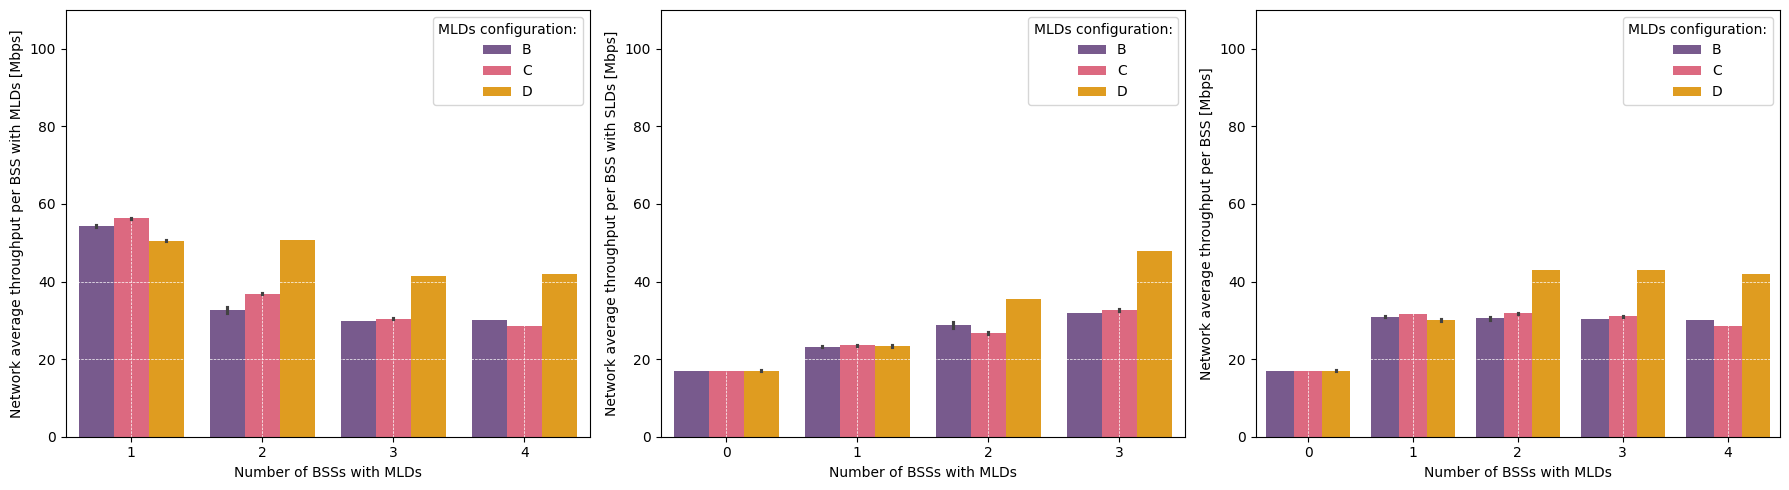

In [89]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average throughput per BSS with MLDs [Mbps]'),
    (df1, 'Network average throughput per BSS with SLDs [Mbps]'),
    (df_sum, 'Network average throughput per BSS [Mbps]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='throughput', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 110)
    else:
        axes[i].set_ylim(0, 110) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_thr_flows4.svg', bbox_inches='tight')
plt.show()

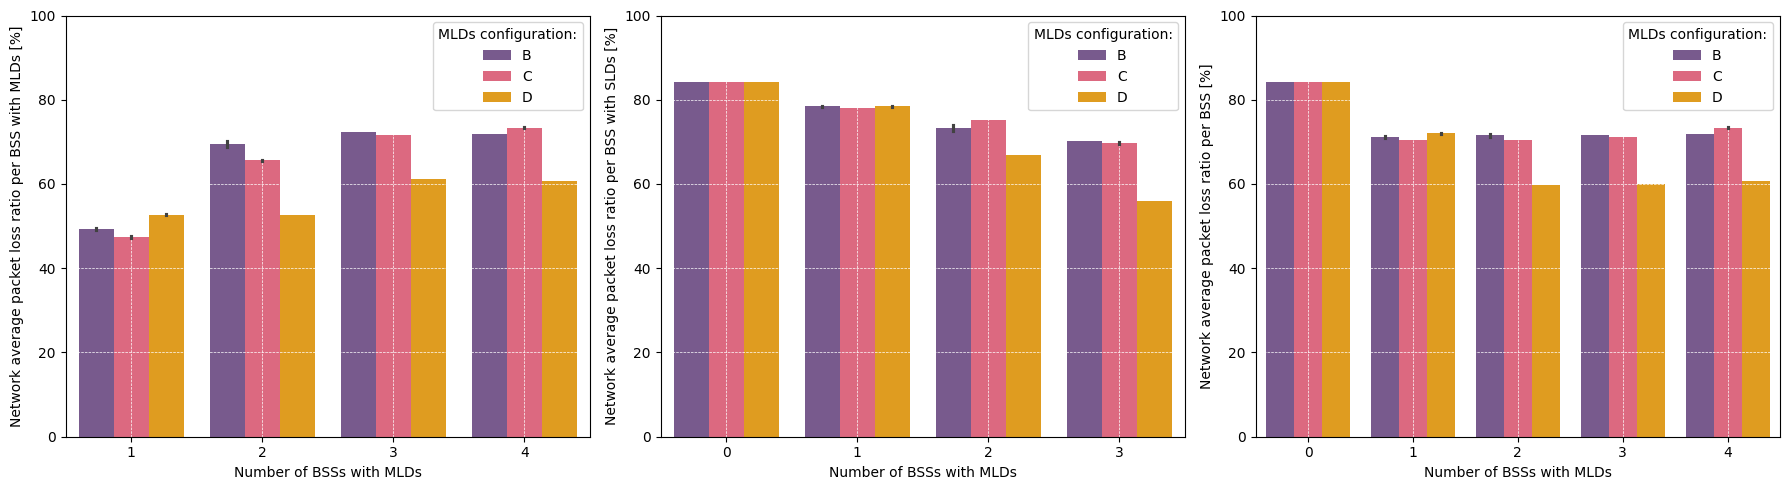

In [90]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average packet loss ratio per BSS with MLDs [%]'),
    (df1, 'Network average packet loss ratio per BSS with SLDs [%]'),
    (df_sum, 'Network average packet loss ratio per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='loss', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 100)
    else:
        axes[i].set_ylim(0, 100) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_loss_flows4.svg', bbox_inches='tight')
plt.show()

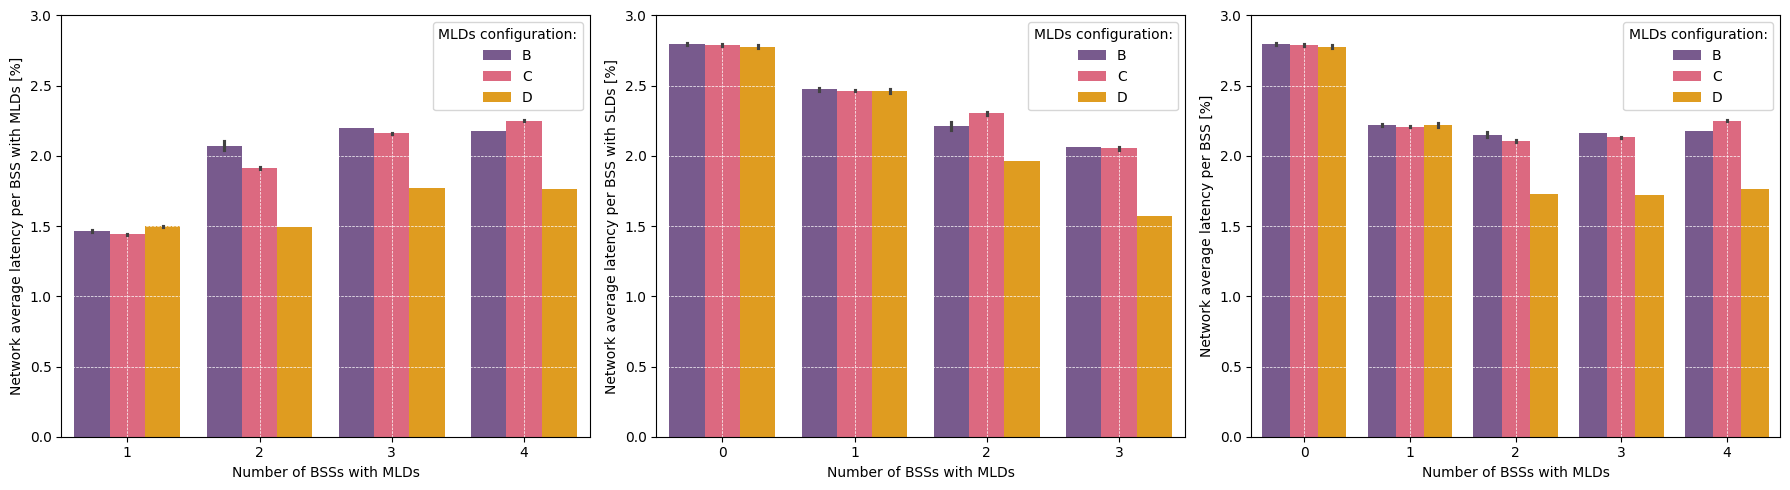

In [91]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average latency per BSS with MLDs [%]'),
    (df1, 'Network average latency per BSS with SLDs [%]'),
    (df_sum, 'Network average latency per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='latency', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 3)
    else:
        axes[i].set_ylim(0, 3) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_latency_flows4.svg', bbox_inches='tight')
plt.show()

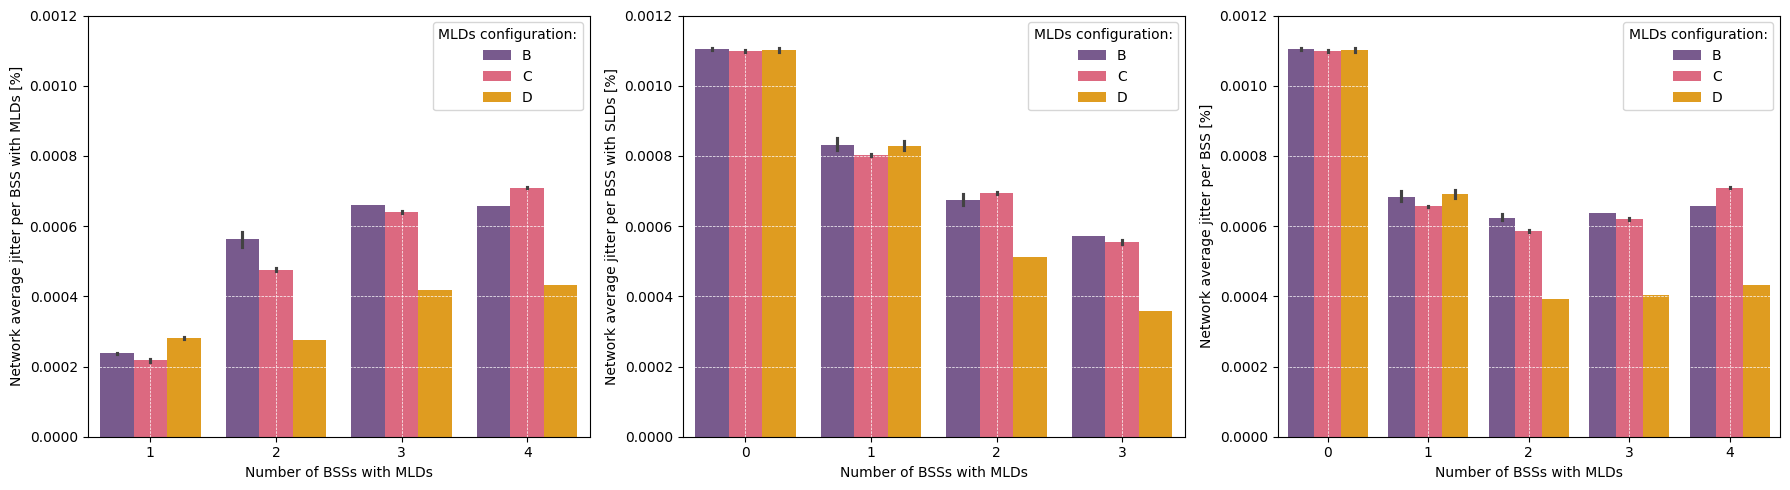

In [92]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average jitter per BSS with MLDs [%]'),
    (df1, 'Network average jitter per BSS with SLDs [%]'),
    (df_sum, 'Network average jitter per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='jitter', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 0.0012)
    else:
        axes[i].set_ylim(0, 0.0012) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_jitter_flows4.svg', bbox_inches='tight')
plt.show()